In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import sys

In [18]:
def inverse_matrix(matrix):
    det = np.linalg.det(matrix)
    # if det == 0:
    #     raise Exception("Matrix is not invertible")
    # else:
    n = matrix.shape[0]
    identity = np.identity(n)
    augmented_matrix = np.column_stack((matrix, identity))
    for i in range(n):
        pivot = augmented_matrix[i, i]
        augmented_matrix[i, :] /= pivot
        for j in range(i + 1, n):
            factor = augmented_matrix[j, i]
            augmented_matrix[j, :] -= factor * augmented_matrix[i, :]
    for i in range(n - 1, -1, -1):
        for j in range(i - 1, -1, -1):
            factor = augmented_matrix[j, i]
            augmented_matrix[j, :] -= factor * augmented_matrix[i, :]
    return augmented_matrix[:, n:]

In [19]:
def load_data(filepath):
    """    
    Parameters:
    filepath (cvs): training data.

    Returns:
    x (np.array) : inputs, attributes.
    y (np.array) : outputs.

    """
    X, y = [], []
    with open(filepath, 'r') as file:
        for line in file:
            x, y_ = line.strip().split(',')
            X.append(float(x))
            y.append(float(y_))
    return np.array(X), np.array(y)


def load_sol_data(filepath):
    """    
    Parameters:
    filepath (cvs): solution data.

    Returns:
    m (int) : polynomial degree.
    w (np.array) : weights.

    """
    with open(filepath, 'r') as file:
        m = int(file.readline().strip())
        w = []
        for line in file:
            w_ = float(line.strip())
            w.append(w_)
    return m, np.array(w)



def create_phi(x, degree):
    """
    This function creates a matrix of x values raised to powers.
    :param x: numpy array of input data
    :param degree: degree of the polynomial
    :return: matrix of x values raised to powers
    """
    matrix = np.zeros((len(x), degree + 1))
    for i in range(len(x)):
        for j in range(degree + 1):
            matrix[i][j] = x[i] ** j
    return matrix


def regularized_linear_regression(phi, t, lambda_):
    """
    Find the best fitting regularized weights for a linear model using equation 3.28 from PRML.

    Parameters:
    X : Training data input. (trainPath)
    y : Training data output. (modelOutput)
    lambda_ : Regularization parameter.

    Returns:
    w : Best regularized weights.
    """
    i, size = phi.shape
    phi_t = phi.transpose()
    phit_phi = np.matmul(phi_t, phi)
    id = np.identity(size)
    phit_phi += lambda_ * id
    phit_phi_inv = inverse_matrix(phit_phi)
    # phit_phi_inv = np.linalg.inv(phit_phi)

    w_reg = np.matmul(phit_phi_inv, phi_t)
    w = np.matmul(w_reg, t)
    return w


# def sweep(X, m, lambda_):
#     """
#     Sweep up to max polynomial (m).

#     Parameters:
#     X : Training data input. (trainPath)
#     m : Given polynomial.
#     lambda_ : Regularization parameter.

#     Returns:
#     weight_list : List of best regularized weights per polynomial.
#     """
#     weight_list = []
#     for i in range(m+1):
#         phi_m = create_phi(X, i)
#         weight = regularized_linear_regression(phi_m, t, 0)
#         weight_list.append(weight)
#     return weight_list


def prediction(X, phi, w):
    """
    Compute prediction for polynomial regression.

    Parameters:
    X (np.array) : Training data input.
    phi (matrix) : Matrix of x values raised to powers.
    w (np.array) : Best regularized weights.

    Returns:
    y(X, phi, w) : prediction.
    """

    return np.dot(phi, w)


def small_phi(phi, r):
    return phi[r]


def errorfunction(y, t):
    error = 0.0
    for i in range(len(y)):
        error += (y[i]-t[i])**2

    return 1/2*error

def split_data(x, t, ratio):
    # Shuffle data
    shuffle_index = np.random.permutation(len(x))
    x = x[shuffle_index]
    t = t[shuffle_index]
    
    # Split data into training and test sets
    split_index = int(len(x) * ratio)
    x_train = x[:split_index]
    t_train = t[:split_index]
    x_test = x[split_index:]
    t_test = t[split_index:]
    
    return x_train, t_train, x_test, t_test

def rms(error, N):
    return np.sqrt((2*error)/N)


In [20]:
def kfold_cv_k(x, t, M, k):
    """
    K-Fold Cross Validation
    
    Parameters:
    x (np.array): inputs, attributes.
    t (np.array): outputs.
    M (int): polynomial degree.
    k (int): number of folds.
    
    Returns:
    avg_error (float): average root mean squared error.
    """
    data = np.concatenate((x.reshape(-1,1), t.reshape(-1,1)), axis=1)
    # folds = np.array_split(data, k)
    error_list = []
    error_TRAINlist = []

    # print(f"data shape = {data.shape}")
    for i in range(k):
        validation_indices = np.array([j for j in range(len(x)) if j % k == i])
        # print(f"k={k}, validation: {validation_indices.shape}")
        # print(validation_indices)
        validation_fold = data[validation_indices]
        # print(f"valid f = {validation_fold.shape}")
        training_indices = np.array([j for j in range(len(x)) if j % k != i])
        # print(f"k={k}, training: {training_indices.shape}")

        training_folds = data[training_indices]
        x_train, t_train = training_folds[:,0], training_folds[:,1]
        phi_train = create_phi(x_train, M)
        w_train = regularized_linear_regression(phi_train, t_train, 0)
        ######
        Y_train = prediction(x_train, phi_train, w_train)
        error_TRAIN = errorfunction(Y_train, t_train)
        error_TRAINlist.append(error_TRAIN)

        ######
        # print(f"w_train = {w_train}")

        x_test, t_test = validation_fold[:,0], validation_fold[:,1]
        phi_test = create_phi(x_test, M)
        y_test = prediction(x_test, phi_test, w_train)
        
        error = errorfunction(y_test, t_test)
        error_list.append(error)
        # print(f"error = {error_list}")

    avg_error = np.mean(error_list)
    avg_TRAINerror = np.mean(error_TRAINlist)
    
    return avg_error, error_list, avg_TRAINerror, error_TRAINlist


def solve_curve_fitting_k(x, t, M, k):

    phi = np.array(create_phi(x, M))
    w = regularized_linear_regression(phi, t, 0.0)
    y = prediction(x, phi, w)    
    error = errorfunction(y, t)
    rms = np.sqrt(2*error/len(x))
    k_fold = kfold_cv_k(x, t, M, k)
    avg_error = k_fold[0]
    errorlist = k_fold[1]
    avg_TRAINerror = k_fold[2]
    error_TRAINlist = k_fold[3]
    # avg_error, errorlist, , error_TRAINlist = kfold_cv_k(x, t, M, k)
    k_rms = np.sqrt(2*avg_error/len(x))
    k_rms_TRAIN = np.sqrt(2*avg_TRAINerror/len(x))

    return w, y, error, rms, avg_error, k_rms, errorlist, k_rms_TRAIN,error_TRAINlist
    # return rms

def plot_tt_k(x, t, m, ratio, k):
    x_train, t_train, x_test, t_test = split_data(x, t, ratio)
    M = np.arange(0, m)
    train_rms = []
    test_rms = []
    for i in M:
        rms = solve_curve_fitting_k(x, t, i, k)
        train_rms.append(rms[7])
        test_rms.append(rms[5])
        
    plt.plot(M, train_rms, '-o', label='Train RMS')
    plt.plot(M, test_rms, '-o', label='Test RMS')
    plt.xlabel('M (degree)')
    plt.ylabel('RMS')
    plt.legend()
    plt.show()
    return  train_rms, test_rms

In [31]:
input = load_data("sampleData/Z")
X, t = input
M =40
k = 5
ratio = 7/10
fit = solve_curve_fitting_k(X, t, M,k)
w = fit[0]
y = fit[1]
error = fit[2]
rms = fit[3]
avg_error = fit[4]
k_rms = fit[5]
errorlist = fit[6]
error_TRAINlist = fit[8]

In [22]:
errorlist

[41.1754897999739,
 3.6034111454018967,
 8.488910350312324,
 0.2411271604910471,
 0.6885676092448727]

In [23]:
error_TRAINlist

[146.32037141934794,
 16.82603598424939,
 33.01592477768154,
 1.1823229590528521,
 3.1292763873427996]

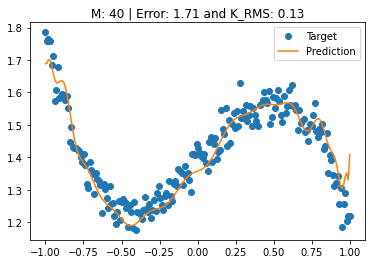

Coefficients: [ 1.35751391e+00  1.81405780e-01  2.77180495e-01  2.90950905e+01
  1.15690066e+01 -7.41649106e+02 -2.72992173e+02  8.78907552e+03
  2.45146566e+03 -5.76361995e+04 -1.21804276e+04  2.21116858e+05
  3.72701813e+04 -4.88772099e+05 -6.95618038e+04  5.27344914e+05
  6.87227056e+04  1.11284390e+04 -2.03685871e+04 -6.01211228e+05
  6.76284404e+03  4.04280493e+05 -4.75244686e+04  1.33672720e+03
 -1.07982542e+04  2.14933185e+05  9.79255759e+04 -1.96982134e+05
  5.62170084e+04 -3.40351968e+05 -2.14062738e+05  1.69530998e+05
  6.40094661e+04  4.81549782e+05  2.85222157e+04 -4.74719970e+05
  1.19455083e+05  1.12520074e+05 -1.56694586e+05  7.85528653e+03
  5.01156567e+04]
Mean Squared Error: 1.7051043491316058
Root-Mean-Squared: 0.13057964424563293


In [32]:
plt.plot(X, t, 'o', label='Target')
plt.plot(X, y, '-', label='Prediction')
plt.legend()
plt.title('M: {:.0f}'.format(M)+' | Error: {:.2f}'.format(avg_error) + ' and K_RMS: {:.2f}'.format(k_rms))
plt.show()

    
print('Coefficients:', w)
# print('Predicted values:', y)
print('Mean Squared Error:', avg_error)
print('Root-Mean-Squared:', k_rms)

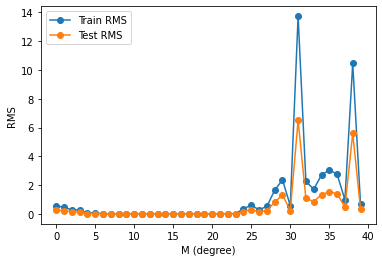

In [25]:
train_rms, test_rms = plot_tt_k(X, t, M, ratio,k)


In [26]:
train_rms

[0.547829575840074,
 0.49615474232728596,
 0.29369143477746895,
 0.2928853436984059,
 0.07981721710441114,
 0.07824680165958227,
 0.028796226979609898,
 0.028237378128527287,
 0.02810904473991214,
 0.028088033419286135,
 0.027942181304560238,
 0.027928340399766775,
 0.02759063608684332,
 0.027495259410061628,
 0.027428683510768145,
 0.02741020289457102,
 0.027140540560906173,
 0.02711814460597188,
 0.027081823425572978,
 0.027053914216800992,
 0.027015897044031168,
 0.026983598498442604,
 0.03239106885216953,
 0.03779573633695428,
 0.37466231672231265,
 0.6146307898703677,
 0.3026202451188551,
 0.5415215454714701,
 1.6600870603184499,
 2.378745874002086,
 0.5861989439752511,
 13.720471820093707,
 2.281686238187539,
 1.7251412568018252,
 2.711210999780015,
 3.063844223350113,
 2.7686274859120514,
 0.993331588444345,
 10.444509940266489,
 0.6814707542717684]

In [27]:
def when_diverges(train, test):
    for i in range(5, len(train)):
        if train[i] > train[i-1] and train[i] > test[i]:
            return i
        if test[i] > test[i-1] and test[i] > train[i]:
            return i
        # if train[i] > train[i-1] != (test[i] > test[i-1]):
        #     return i
    return None


In [28]:
index = when_diverges(train_rms, test_rms)
index - 1

21